In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import scipy.optimize 
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import ttest_ind
import math
import scipy.integrate as integrate
import scipy.special as special
import glob
import statistics

np.set_printoptions(suppress=True)

In [2]:
import scipy 
print(scipy.__version__)


1.5.2


In [3]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)



In [4]:
# Condition folder - select data location
datapath = 'csv/D5_cont-IL12_cont-stim/'
cond = 'cont-stim_cont-IL12'

# datapath = 'csv/D5_cont-IL12_rem-stim/'
# cond = 'cont-IL12_rem-stim'

# datapath = 'csv/D5_rem-IL12_cont-stim/'
# cond = 'rem-IL12_cont-stim'

# datapath = 'csv/D5_rem-IL12_rem-stim/'
# cond = 'rem-IL12_rem-stim'


### Function definitions

In [5]:
# gauss
def gauss(x, mu, sigma, h):
    return h*(1/((2*np.pi*(sigma**2))**0.5))*np.exp(-((x-mu)**2)/(2*(sigma**2)))

def load_npz(sample_str):
    df_all = pd.DataFrame()
    df_x_hist = pd.DataFrame()
    df_y_hist = pd.DataFrame()
    conc = []
    for file_name in glob.glob(datapath+ sample_str + '*.npz'):
        name = file_name.split(sample_str + '_')[1]
        name= name.split("ng.npz")[0]
        name = float(name)
        conc.append(name)
        x = np.load(file_name)
        x_hist = x['arr_1'] 
        y_hist = x['arr_2'] 
        df_all = df_all.append(pd.DataFrame(x['arr_0']).T)
        df_x_hist = df_x_hist.append(pd.DataFrame(x['arr_1']).T)
        df_y_hist = df_y_hist.append(pd.DataFrame(x['arr_2']).T)
    df_all['conc'] = conc
    df_x_hist['conc'] = conc
    df_y_hist['conc'] = conc
    df_all = df_all.sort_values(by='conc')
    df_x_hist = df_x_hist.sort_values(by='conc')
    df_y_hist = df_y_hist.sort_values(by='conc')
    return([df_all, df_x_hist, df_y_hist])

def load_npz_wt(sample_str):
    df_x_hist = pd.DataFrame()
    df_y_hist = pd.DataFrame()
    conc = []
    for file_name in glob.glob(datapath+ sample_str + '*.npz'):
        name = file_name.split(sample_str + '_')[1]
        name= name.split("ng.npz")[0]
        name = float(name)
        conc.append(name)
        x = np.load(file_name)
        x_hist = x['arr_0'] 
        y_hist = x['arr_1'] 
        df_x_hist = df_x_hist.append(pd.DataFrame(x['arr_0']).T)
        df_y_hist = df_y_hist.append(pd.DataFrame(x['arr_1']).T)
    df_x_hist['conc'] = conc
    df_y_hist['conc'] = conc
    df_x_hist = df_x_hist.sort_values(by='conc')
    df_y_hist = df_y_hist.sort_values(by='conc')
    return([df_x_hist, df_y_hist])

def calc_fractions(df, df_x_hist, df_y_hist, df_x_hist_wt, df_y_hist_wt, sample_str):
    sum_low_vec = []
    sum_high_vec = []
    per_low_vec = []
    per_high_vec = []
    for i in range(len(df)):
        print(i)
        # load gauss params, x_hist, y_hist
        params = df.iloc[i,:].values
        x_hist = df_x_hist.iloc[i,1:-1].values
        y_hist = df_y_hist.iloc[i,0:-1].values
        x_hist_wt = df_x_hist_wt.iloc[i,1:-1].values
        y_hist_wt = df_y_hist_wt.iloc[i,0:-1].values
        mu1 = params[0]
        sigma1 = params[1]
        h1 = params[2]
        mu2 = mu1 + params[3]
        sigma2 = params[4]
        h2 = params[5]
        conc = params[6]
        
        # calculate gaussians
        # only use x between 2.75 and 5 to avoid any spurious gate identification at low x
        x_trunc = x_hist[np.where(x_hist > 2.75)]
        y1 = gauss(x_trunc, mu1, sigma1, h1)
        y2 = gauss(x_trunc, mu2, sigma2, h2)
        # also calc full gaussian for plotting
        y1_full = gauss(x_hist, mu1, sigma1, h1)
        y2_full = gauss(x_hist, mu2, sigma2, h2)
        diff = y1 - y2 # difference
        yz = np.multiply(diff[0:-1], diff[1:])# zero crossing; x at which the sign of diff switches
        yind_trunc = np.where(yz < 0)[0]
        yind_trunc = yind_trunc[0]
        x_sil = x_trunc[yind_trunc] # this is the gate between low (silent) and high populations
        yind = np.where(x_hist == x_sil)[0]
        yind = yind[0]
        # now sum low and high populations
        sum_low = sum(y_hist[0:yind])
        sum_high = sum(y_hist[yind:])
        sum_low_vec.append(sum_low)
        sum_high_vec.append(sum_high)
        per_low = 100*sum_low / (sum_low + sum_high)
        per_low_vec.append(per_low)
        per_high = 100*sum_high / (sum_low + sum_high)
        per_high_vec.append(per_high)
        
        # plot y1 and y2 with gate
        # reporter histogram
        plt.figure(figsize=(4.5,4.5))
        plt.plot(x_hist,y_hist, color = 'k', alpha=0.001)
        plt.fill_between(x_hist, 0, y_hist, facecolor='k', alpha=0.25, interpolate=True)
        # wildtype histogram
        plt.plot(x_hist_wt,y_hist_wt, color = 'k', alpha=0.25, linewidth=1)
#         plt.fill_between(x_hist_wt, 0, y_hist_wt, facecolor='k', alpha=0.05, interpolate=True)
        # curve fits
        plt.plot(x_hist, y1_full, color = 'b', linestyle='dashed')
        plt.plot(x_hist, y2_full, color = 'r', linestyle='dashed')
        plt.axvline(x = x_sil, color = 'k',alpha = 0.8, linestyle = 'dashed')
        plt.xlim(left=1, right=5)
        plt.ylim(bottom=0)
        # add text for fraction low and fraction high 
        plt.text(1.2, 0.9*max(y_hist), str(round(per_low,1)))
        plt.text(4.2, 0.9*max(y_hist), str(round(per_high,1)))
        # title and save
        #plt.title(sample_str + ", " + str(conc) + "ng/ml IL-12")
        plt.tick_params(labelleft=False, labelbottom=False)
        plt.savefig(datapath + sample_str + "_" + str(conc) + "ILI12.pdf")
        plt.show()
        print(sample_str + "_" + str(conc) + "ILI12")
        print('mu1:', mu1)
        print('sigma1:', sigma1)
        print('dmu', params[3])
        print('mu2:', mu2)
        print('sigma2:', sigma2)
               
    # update dataframe for return
    df['sum_low'] = sum_low_vec
    df['sum_high'] = sum_high_vec
    df['per_low'] = per_low_vec
    df['per_high'] = per_high_vec
    df['conc_pc'] = df['conc']+0.0001 # also add conc column with pseudocount for semilogx plotting
    return(df)


def mean(a,b):
    result = (a+b)/2
    return(result)

def difference(a,b):
    result = a-b
    return(result)
    


### Calculate fractions for all samples 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


het1
0


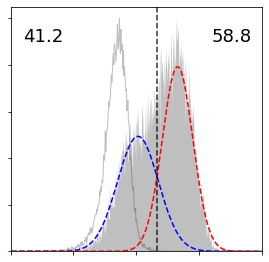

het1_0.05ILI12
mu1: 3.0272922040517107
sigma1: 0.3263770941494043
dmu 0.6312381160729219
mu2: 3.6585303201246324
sigma2: 0.24393282444788603
1


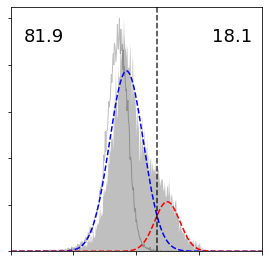

het1_0.2ILI12
mu1: 2.844318206209791
sigma1: 0.2700000000000001
dmu 0.6486776980373331
mu2: 3.492995904247124
sigma2: 0.20000000000000007
2


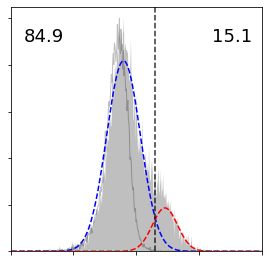

het1_0.5ILI12
mu1: 2.797622886205767
sigma1: 0.2700000000000001
dmu 0.6591535975183037
mu2: 3.4567764837240706
sigma2: 0.20000000000000004
3


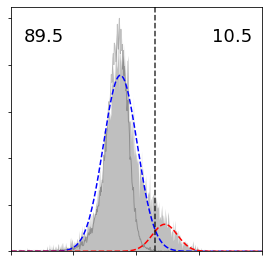

het1_1.0ILI12
mu1: 2.7466681049515813
sigma1: 0.2700000000000001
dmu 0.7080869428803439
mu2: 3.454755047831925
sigma2: 0.20000000000000004
hom1
0


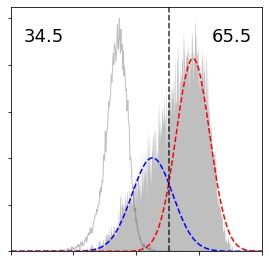

hom1_0.05ILI12
mu1: 3.257229486800741
sigma1: 0.3263770941494043
dmu 0.6462052460119222
mu2: 3.9034347328126633
sigma2: 0.26753774082764775
1


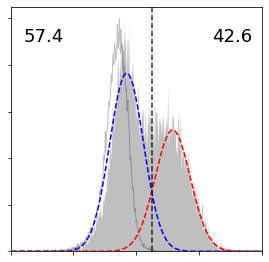

hom1_0.2ILI12
mu1: 2.8468374242173136
sigma1: 0.2700000000000001
dmu 0.7337058037749883
mu2: 3.580543227992302
sigma2: 0.2811379636800564
2


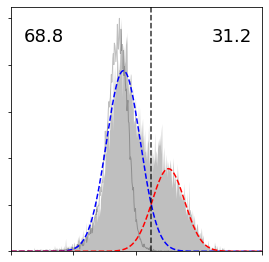

hom1_0.5ILI12
mu1: 2.7954837551878584
sigma1: 0.2700000000000001
dmu 0.7167747690524149
mu2: 3.5122585242402735
sigma2: 0.25933322900117706
3


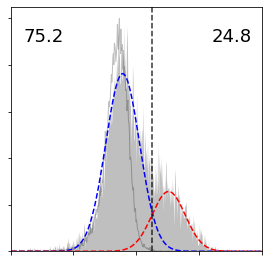

hom1_1.0ILI12
mu1: 2.783446414277243
sigma1: 0.2700000000000001
dmu 0.7318837671866044
mu2: 3.515330181463847
sigma2: 0.26492539769392315
het2
0


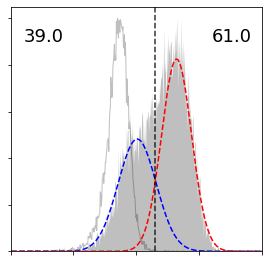

het2_0.05ILI12
mu1: 3.0149940638985635
sigma1: 0.3027837766958885
dmu 0.627214079516559
mu2: 3.6422081434151226
sigma2: 0.23867641909095869
1


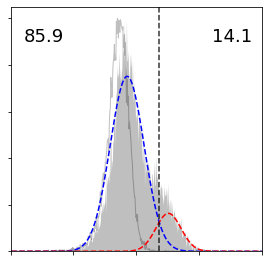

het2_0.2ILI12
mu1: 2.854797839732636
sigma1: 0.2700000000000001
dmu 0.6576236905514387
mu2: 3.5124215302840747
sigma2: 0.20000000000000004
2


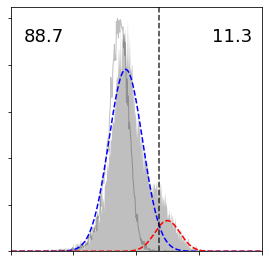

het2_0.5ILI12
mu1: 2.8320069544883615
sigma1: 0.2700000000000001
dmu 0.6636874896327404
mu2: 3.495694444121102
sigma2: 0.20000000000000004
3


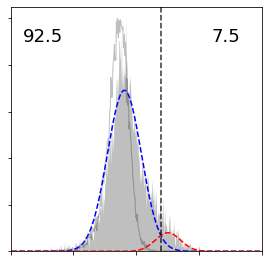

het2_1.0ILI12
mu1: 2.8113207572086547
sigma1: 0.2700000000000001
dmu 0.6931720291442408
mu2: 3.5044927863528956
sigma2: 0.20000000000000004
hom2
0


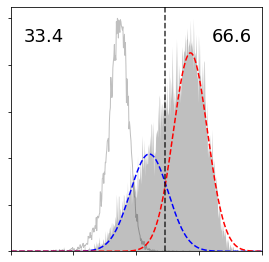

hom2_0.05ILI12
mu1: 3.2071328632970917
sigma1: 0.3027837766958885
dmu 0.6560648190384024
mu2: 3.8631976823354943
sigma2: 0.27069141264866703
1


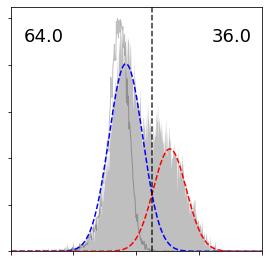

hom2_0.2ILI12
mu1: 2.8346223849925862
sigma1: 0.2700000000000001
dmu 0.6999519207133085
mu2: 3.5345743057058945
sigma2: 0.26302511971265574
2


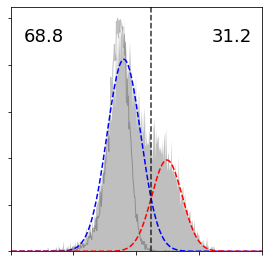

hom2_0.5ILI12
mu1: 2.8030540187923307
sigma1: 0.2700000000000001
dmu 0.6859614061229955
mu2: 3.4890154249153262
sigma2: 0.2422963548412058
3


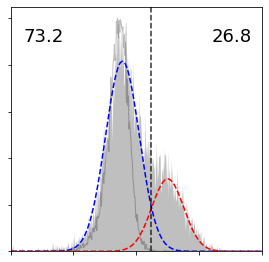

hom2_1.0ILI12
mu1: 2.7799845679315243
sigma1: 0.2700000000000001
dmu 0.721150435781616
mu2: 3.50113500371314
sigma2: 0.2544891980460114
het3
0


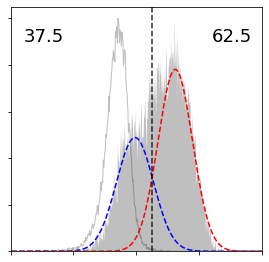

het3_0.05ILI12
mu1: 2.980223440928344
sigma1: 0.2953235214040847
dmu 0.6414379576869668
mu2: 3.621661398615311
sigma2: 0.27463501266707563
1


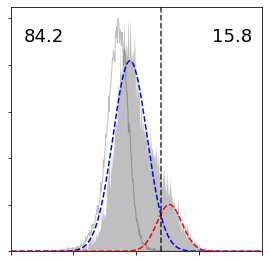

het3_0.2ILI12
mu1: 2.90107727635456
sigma1: 0.2700000000000001
dmu 0.6268992388023875
mu2: 3.5279765151569475
sigma2: 0.20000000000000012
2


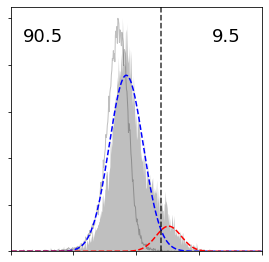

het3_0.5ILI12
mu1: 2.8407203903323954
sigma1: 0.2700000000000001
dmu 0.6742601943237112
mu2: 3.5149805846561066
sigma2: 0.20000000000000004
3


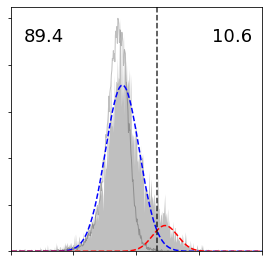

het3_1.0ILI12
mu1: 2.779575604754978
sigma1: 0.2700000000000001
dmu 0.6797709881222158
mu2: 3.4593465928771936
sigma2: 0.20000000000000004
hom3
0


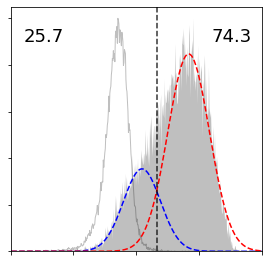

hom3_0.05ILI12
mu1: 3.091284005092049
sigma1: 0.2953235214040847
dmu 0.7436179135368477
mu2: 3.834901918628897
sigma2: 0.33083629446038704
1


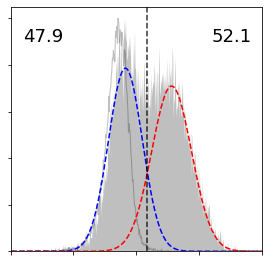

hom3_0.2ILI12
mu1: 2.82759344732892
sigma1: 0.2700000000000001
dmu 0.7355795693307858
mu2: 3.5631730166597055
sigma2: 0.3165716101515626
2


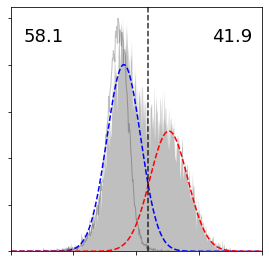

hom3_0.5ILI12
mu1: 2.8021228695112037
sigma1: 0.2700000000000001
dmu 0.7169137118532948
mu2: 3.5190365813644986
sigma2: 0.3000698084144456
3


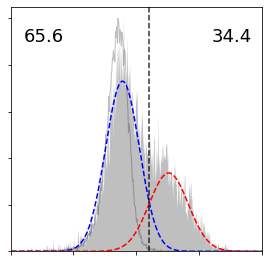

hom3_1.0ILI12
mu1: 2.7811265747124776
sigma1: 0.2700000000000001
dmu 0.73569868484714
mu2: 3.5168252595596177
sigma2: 0.3109013163369898


In [6]:


# het1
print('het1')
result = load_npz('het1')
df_het1 = result[0]
df_x_hist_het1 = result[1]
df_y_hist_het1 = result[2]
result_wt = load_npz_wt('wt1')
df_x_hist_wt1 = result_wt[0]
df_y_hist_wt1 = result_wt[1]
df_het1 = calc_fractions(df_het1, df_x_hist_het1, df_y_hist_het1, df_x_hist_wt1, df_y_hist_wt1, 'het1')

# hom1
print('hom1')
result = load_npz('hom1')
df_hom1 = result[0]
df_x_hist_hom1 = result[1]
df_y_hist_hom1 = result[2]
result_wt = load_npz_wt('wt1')
df_x_hist_wt1 = result_wt[0]
df_y_hist_wt1 = result_wt[1]
df_hom1 = calc_fractions(df_hom1, df_x_hist_hom1, df_y_hist_hom1, df_x_hist_wt1, df_y_hist_wt1, 'hom1')


# het2
print('het2')
result = load_npz('het2')
df_het2 = result[0]
df_x_hist_het2 = result[1]
df_y_hist_het2 = result[2]
result_wt = load_npz_wt('wt2')
df_x_hist_wt2 = result_wt[0]
df_y_hist_wt2 = result_wt[1]
df_het2 = calc_fractions(df_het2, df_x_hist_het2, df_y_hist_het2, df_x_hist_wt2, df_y_hist_wt2, 'het2')

# hom2
print('hom2')
result = load_npz('hom2')
df_hom2 = result[0]
df_x_hist_hom2 = result[1]
df_y_hist_hom2 = result[2]
result_wt = load_npz_wt('wt2')
df_x_hist_wt2 = result_wt[0]
df_y_hist_wt2 = result_wt[1]
df_hom2 = calc_fractions(df_hom2, df_x_hist_hom2, df_y_hist_hom2, df_x_hist_wt2, df_y_hist_wt2, 'hom2')

# het3
print('het3')
result = load_npz('het3')
df_het3 = result[0]
df_x_hist_het3 = result[1]
df_y_hist_het3 = result[2]
result_wt = load_npz_wt('wt3')
df_x_hist_wt3 = result_wt[0]
df_y_hist_wt3 = result_wt[1]
df_het3 = calc_fractions(df_het3, df_x_hist_het3, df_y_hist_het3, df_x_hist_wt3, df_y_hist_wt3, 'het3')

# hom3
print('hom3')
result = load_npz('hom3')
df_hom3 = result[0]
df_x_hist_hom3 = result[1]
df_y_hist_hom3 = result[2]
result_wt = load_npz_wt('wt3')
df_x_hist_wt3 = result_wt[0]
df_y_hist_wt3 = result_wt[1]
df_hom3 = calc_fractions(df_hom3, df_x_hist_hom3, df_y_hist_hom3, df_x_hist_wt3, df_y_hist_wt3, 'hom3')



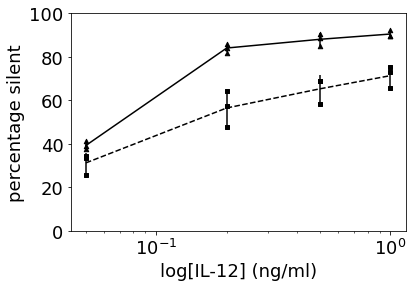

In [7]:
# make new combined df of hom and het 
frac_off_summary = pd.concat([df_het1['conc'], df_het1['conc_pc'], df_het1['per_low'], df_het2['per_low'], df_het3['per_low'], df_hom1['per_low'], df_hom2['per_low'],df_hom3['per_low']], axis=1) 
frac_off_summary.columns = ['conc', 'conc_pc', 'het1', 'het2', 'het3', 'hom1', 'hom2', 'hom3']
frac_off_summary

# frac_off_summary['ave_het'] = frac_off_summary.apply(lambda row : mean(row['het1'], row['het2'], row['het3']), axis = 1)
frac_off_summary['ave_het'] = frac_off_summary.apply(lambda row : row[['het1', 'het2','het3']].mean(), axis = 1)
frac_off_summary['ave_hom'] = frac_off_summary.apply(lambda row : row[['hom1', 'hom2','hom3']].mean(), axis = 1)
frac_off_summary['sd_het'] = frac_off_summary.apply(lambda row : row[['het1', 'het2','het3']].std(), axis = 1)
frac_off_summary['sd_hom'] = frac_off_summary.apply(lambda row : row[['hom1', 'hom2','hom3']].std(), axis = 1)
# frac_off_summary['ave_hom'] = frac_off_summary.apply(lambda row : mean(row['hom1'], row['hom2'], row['hom3']), axis = 1)
frac_off_summary['diff'] = frac_off_summary.apply(lambda row : difference(row['ave_het'], row['ave_hom']), axis = 1)  


# plot (line plot)
ax = frac_off_summary.plot.scatter(x = 'conc_pc', y = 'het1', marker='^', logx = True, ylim = (0,100),  color = 'k')
frac_off_summary.plot.scatter(x = 'conc_pc', y = 'het2', marker='^', logx = True, ylim = (0,100), ax=ax, color = 'k')
frac_off_summary.plot.scatter(x = 'conc_pc', y = 'het3', marker='^', logx = True, ylim = (0,100), ax=ax, color = 'k')
ax.errorbar(frac_off_summary['conc_pc'], frac_off_summary['ave_het'], yerr = frac_off_summary['sd_het'], color = 'k')
frac_off_summary.plot.scatter(x = 'conc_pc', y = 'hom1', marker='s', logx = True, ylim = (0,100), ax=ax, color = 'k')
frac_off_summary.plot.scatter(x = 'conc_pc', y = 'hom2', marker='s', logx = True, ylim = (0,100), ax=ax, color = 'k')
frac_off_summary.plot.scatter(x = 'conc_pc', y = 'hom3', marker='s', logx = True, ylim = (0,100), ax=ax, color = 'k')
ax.errorbar(frac_off_summary['conc_pc'], frac_off_summary['ave_hom'], yerr = frac_off_summary['sd_hom'], linestyle = 'dashed', color = 'k')
plt.xlabel('log[IL-12] (ng/ml)')
plt.ylabel('percentage silent')
plt.savefig(datapath + 'het_hom_frac.pdf')




In [8]:
frac_off_summary
tidy = frac_off_summary.melt(id_vars=['conc'], value_vars = ['ave_hom', 'ave_het', 'sd_hom', 'sd_het']).rename(columns=str.title)
x = tidy[0:7].rename(columns = {'Variable': 'Sample', 'Value': 'Mean'})
y = tidy[8:16]["Value"]
y = y.reset_index()
x['Std'] = y['Value']
tidy = x
tidy

,Conc,Sample,Mean,Std
0,0.05,ave_hom,31.196373,4.760779
1,0.20,ave_hom,56.442197,8.108866
2,0.50,ave_hom,65.244748,6.160275
3,1.00,ave_hom,71.298497,5.060526
4,0.05,ave_het,39.216293,1.840736
5,0.20,ave_het,84.009903,2.011867
6,0.50,ave_het,88.024200,2.889162


In [9]:
frac_off_summary

,conc,conc_pc,het1,het2,het3,hom1,hom2,hom3,ave_het,ave_hom,sd_het,sd_hom,diff
0,0.05,0.0501,41.157407,38.995644,37.495826,34.466986,33.387597,25.734537,39.216293,31.196373,1.840736,4.760779,8.019919
0,0.20,0.2001,81.914894,85.926782,84.188034,57.412763,64.022099,47.891730,84.009903,56.442197,2.011867,8.108866,27.567706
0,0.50,0.5001,84.861392,88.686504,90.524703,68.781561,68.821172,58.131511,88.024200,65.244748,2.889162,6.160275,22.779452
0,1.00,1.0001,89.453529,92.455336,89.430673,75.167327,73.156578,65.571584,90.446513,71.298497,1.739729,5.060526,19.148016


In [10]:
tidy = frac_off_summary.melt(id_vars='conc', value_vars = ['het1', 'het2']).rename(columns=str.title)

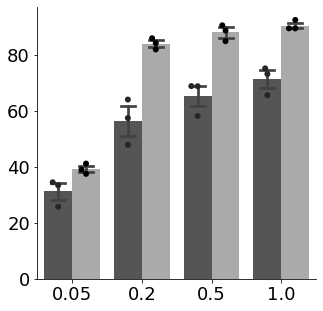

In [11]:
# plot (column plot)
fig, ax1 = plt.subplots(figsize=(5, 5))
tidy2 = frac_off_summary.melt(id_vars='conc', value_vars = ['hom1', 'hom2', 'hom3', 'het1', 'het2', 'het3']).rename(columns=str.title)
tidy2['Sample'] = np.where((tidy2['Variable'] == 'het1') | (tidy2['Variable'] == 'het2') | (tidy2['Variable'] == 'het3'), 'het', 'hom')
sns.barplot(x="Conc", y="Value", data=tidy2, estimator=np.mean, ci=85, capsize=.2, hue="Sample",  palette="gist_gray")
sns.swarmplot(x = 'Conc', y = 'Value', hue = 'Sample', data = tidy2, ax = ax1, dodge=True, color="k", s = 6)
sns.despine(fig)
plt.legend('', frameon=False)
plt.xlabel('')
plt.ylabel('')

plt.savefig(datapath + 'het_hom_frac_bars.pdf')



In [12]:
# add t-test

# first create ID column containing both Conc and Variable
tidy2['ID'] = tidy2.apply(lambda row: str(row.Conc) + "_" + row.Sample, axis=1)
tidy2

# test significance

# 0.05
group1_c1 = tidy2.where(tidy2.ID== '0.05_hom').dropna()['Value']
group2_c1 = tidy2.where(tidy2.ID== '0.05_het').dropna()['Value']
tt_c1 = scipy.stats.ttest_ind(group1_c1,group2_c1)
# 0.2
group1_c2 = tidy2.where(tidy2.ID== '0.2_hom').dropna()['Value']
group2_c2 = tidy2.where(tidy2.ID== '0.2_het').dropna()['Value']
tt_c2 = scipy.stats.ttest_ind(group1_c2,group2_c2)
# 0.5
group1_c3 = tidy2.where(tidy2.ID== '0.5_hom').dropna()['Value']
group2_c3 = tidy2.where(tidy2.ID== '0.5_het').dropna()['Value']
tt_c3 = scipy.stats.ttest_ind(group1_c3,group2_c3)
# 0.1
group1_c4 = tidy2.where(tidy2.ID== '1.0_hom').dropna()['Value']
group2_c4 = tidy2.where(tidy2.ID== '1.0_het').dropna()['Value']
tt_c4 = scipy.stats.ttest_ind(group1_c4,group2_c4)


In [13]:
print(tt_c1)
print(tt_c2)
print(tt_c3)
print(tt_c4)

Ttest_indResult(statistic=-2.7214419425804364, pvalue=0.05290803695778566)
Ttest_indResult(statistic=-5.715174073762818, pvalue=0.004636729807890073)
Ttest_indResult(statistic=-5.7987046330586605, pvalue=0.0043982386225786835)
Ttest_indResult(statistic=-6.197712695164926, pvalue=0.0034464595608392525)


In [14]:
frac_off_summary

,conc,conc_pc,het1,het2,het3,hom1,hom2,hom3,ave_het,ave_hom,sd_het,sd_hom,diff
0,0.05,0.0501,41.157407,38.995644,37.495826,34.466986,33.387597,25.734537,39.216293,31.196373,1.840736,4.760779,8.019919
0,0.20,0.2001,81.914894,85.926782,84.188034,57.412763,64.022099,47.891730,84.009903,56.442197,2.011867,8.108866,27.567706
0,0.50,0.5001,84.861392,88.686504,90.524703,68.781561,68.821172,58.131511,88.024200,65.244748,2.889162,6.160275,22.779452
0,1.00,1.0001,89.453529,92.455336,89.430673,75.167327,73.156578,65.571584,90.446513,71.298497,1.739729,5.060526,19.148016


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


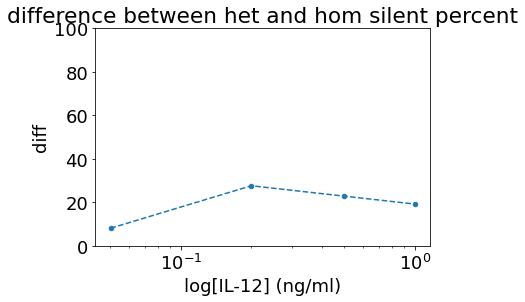

In [15]:
ax = frac_off_summary.plot.scatter(x = 'conc_pc', y = 'diff', logx = True)
frac_off_summary.plot(x = 'conc_pc', y = 'diff', linestyle = 'dashed', logx = True, ylim = (0,100), ax=ax, legend = False)
plt.title('difference between het and hom silent percent')
plt.xlabel('log[IL-12] (ng/ml)')
plt.savefig(datapath + 'het_hom_diff.pdf')
